In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((64, 64)),
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((64, 64)),
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    
    return train_loader, test_loader

In [0]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size
        
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False)
        self.norm1 = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.norm4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False)

        self.relu = nn.LeakyReLU(0.2)


    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.relu(self.norm3(self.conv3(x)))
        x = self.relu(self.norm4(self.conv4(x)))
        x = torch.tanh(self.conv5(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)
        self.norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.norm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=0)

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.relu(self.norm3(self.conv3(x)))
        x = self.relu(self.norm4(self.conv4(x)))
        x = torch.sigmoid(self.conv5(x))
        return x

In [0]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

def train(gmodel: Generator, dmodel: Discriminator, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
    train_loader, test_loader = prepare_data_loaders(batch_size=batch_size)
    
    gmodel = gmodel.to(device)
    dmodel = dmodel.to(device)
    
    gmodel.train()
    dmodel.train()
    
    criterion = nn.BCELoss()
    
    g_optim = optim.Adam(gmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    d_optim = optim.Adam(dmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    for epoch_idx in range(0, n_epochs):
        
        g_loss, d_loss = 0, 0
        
        for image_data, _ in tqdm.tqdm(train_loader):
            # discriminator update
            dmodel.zero_grad()
            
            # real data pass
            image_data = image_data.to(device)
            
            batch_size = image_data.shape[0]
            labels = torch.ones(batch_size, device=device).float()
            
            d_output = dmodel(image_data)
            d_err_real = criterion(d_output, labels)
            d_err_real.backward()
            d_loss += d_err_real.item() / batch_size
            
            # fake data pass
            noise = torch.randn(batch_size, gmodel.latent_size, 1, 1, device=device)
            fake_image_data = gmodel(noise)
            labels = torch.zeros(batch_size, device=device).float()
            
            d_output = dmodel(fake_image_data.detach())
            d_error_fake = criterion(d_output, labels)
            d_error_fake.backward()
            d_loss += d_error_fake.item() / batch_size
    
            d_optim.step()
            
            # generator update
            gmodel.zero_grad()
            
            labels = torch.ones(batch_size, device=device)
            d_output = dmodel(fake_image_data)
            g_error = criterion(d_output, labels)
            g_error.backward()
            g_loss += g_error.item() / batch_size 
            g_optim.step()
            
        if (epoch_idx + 1) % log_epochs == 0:
            print(f"[{epoch_idx+1}/{n_epochs}]: d_loss = {d_loss:.2f} g_loss {g_loss:.2f}")

    gmodel.eval()
    dmodel.eval()
    
    return gmodel, dmodel

In [77]:
dmodel = Discriminator()
gmodel = Generator(100)

dmodel.apply(weights_init)
gmodel.apply(weights_init)

gmodel, dmodel = train(gmodel, dmodel, n_epochs=15, batch_size=256, device='cuda')


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)

100%|█████████▉| 234/235 [03:10<00:00,  1.23it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)

100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[1/15]: d_loss = 0.82 g_loss 3.93



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[2/15]: d_loss = 0.43 g_loss 3.90



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[3/15]: d_loss = 0.54 g_loss 3.87



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[4/15]: d_loss = 0.46 g_loss 4.15



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[5/15]: d_loss = 0.80 g_loss 3.17



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[6/15]: d_loss = 1.29 g_loss 2.02



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[7/15]: d_loss = 0.68 g_loss 2.92



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[8/15]: d_loss = 0.01 g_loss 5.68



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[9/15]: d_loss = 0.00 g_loss 7.01



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[10/15]: d_loss = 0.00 g_loss 7.76



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[11/15]: d_loss = 0.00 g_loss 8.22



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[12/15]: d_loss = 0.00 g_loss 8.34



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[13/15]: d_loss = 0.00 g_loss 8.89



100%|██████████| 235/235 [03:10<00:00,  1.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[14/15]: d_loss = 0.00 g_loss 8.08



100%|██████████| 235/235 [03:10<00:00,  1.24it/s]

[15/15]: d_loss = 0.00 g_loss 8.16


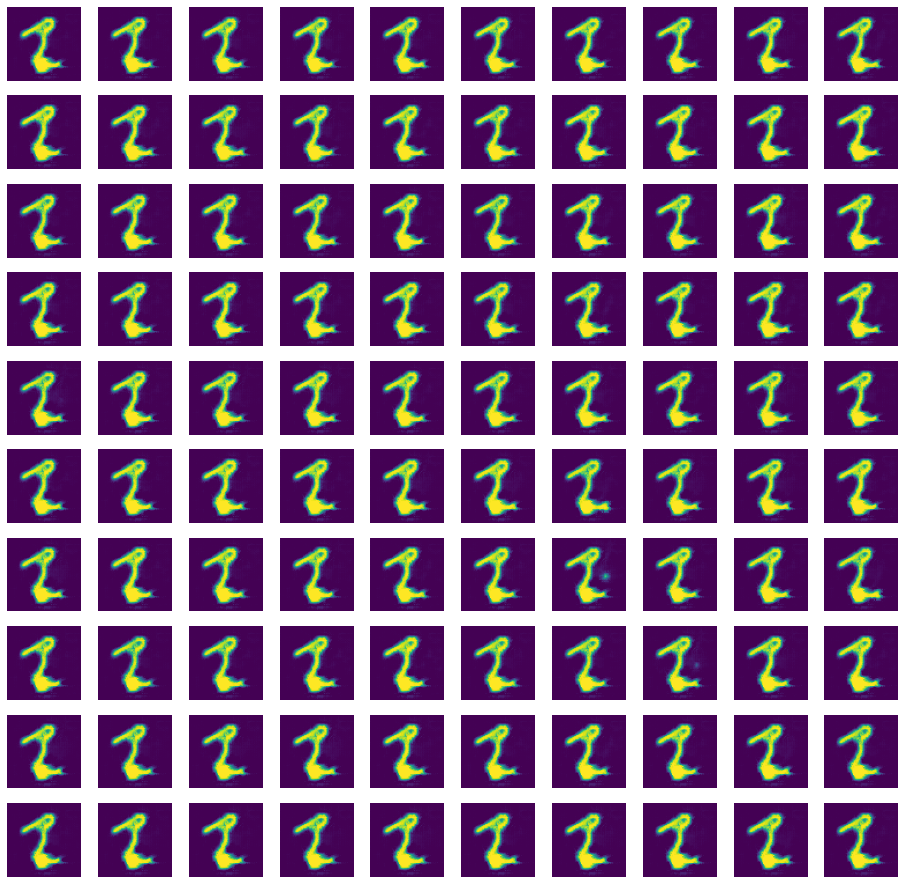

In [78]:
random_sample = gmodel(torch.randn(100, 100, 1, 1).to('cuda')).view(100, 64, 64).data.cpu().numpy()

plt.figure(figsize=(16, 16))
for idx in range(0, 100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample[idx, ...])
    plt.clim(0, 1)
    plt.axis('off')